In [1]:
# Model de Predicció d'Enfrontaments - La Liga 2023-2024
print("🚀 Iniciant Model de Predicció d'Enfrontaments...")
print("=" * 60)

# Importació de llibreries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració
plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

print("✅ Llibreries importades correctament")

🚀 Iniciant Model de Predicció d'Enfrontaments...
✅ Llibreries importades correctament


In [2]:
print("Carregant dades...")

# Carregament de dades
df_classificacio = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-2023-2024.xlsx', 
                                sheet_name='ClassificacióGeneral')

df_partits = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-2023-2024.xlsx', 
                           sheet_name='StatsPartit')

print(f"Dades de classificació: {df_classificacio.shape}")
print(f"Dades de partits: {df_partits.shape}")
print(f"Equips la Liga: {len(df_classificacio['Team'].unique())}")
print(f"Partits analitzats: {len(df_partits)}")


print("Equips temporada 2023-2024:")
for equip in df_classificacio['Team']:
    print(equip)
print('Dades llegides correctament')

Carregant dades...
Dades de classificació: (20, 27)
Dades de partits: (760, 35)
Equips la Liga: 20
Partits analitzats: 760
Equips temporada 2023-2024:
Real Madrid
Barcelona
Girona
Atlético Madrid
Athletic Club
Real Sociedad
Real Betis
Villarreal
Valencia
Alavés
Osasuna
Getafe
Celta Vigo
Sevilla
Mallorca
Las Palmas
Rayo Vallecano
Cádiz
Almería
Granada
Dades llegides correctament


In [3]:
#Aqui fusionem les dades de classificacio i partits per crear un dataset 
# complet amb les estadístiques de cada equip
# És perfecte per a poder predir partits individuals i correlacions

print("PREPARACIÓ DE DADES")
print("=" * 50)

# Funció per obtenir estadístiques d'un equip
def obtenir_stats_equip(equip_nom, df_classificacio):
    """Obtenim les estadístiques d'un equip específic"""
    if equip_nom in df_classificacio['Team'].values:
        return df_classificacio[df_classificacio['Team'] == equip_nom].iloc[0]
    else:
        # Si no trobem l'equip, retornem valors mitjans
        return df_classificacio.mean()

# Funció per crear features dels equips
def crear_features_equips(df_partits, df_classificacio):
    """Creem features combinant estadístiques dels equips amb dades de partits"""
    df_nou = df_partits.copy()
    
    # Columnes de classificació (excloent 'Team')
    stats_columns = [col for col in df_classificacio.columns if col != 'Team']
    
    # Afegim estadístiques de l'equip local
    for col in stats_columns:
        df_nou[f'Home_{col}'] = df_nou['Home Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    # Afegim estadístiques de l'equip visitant
    for col in stats_columns:
        df_nou[f'Away_{col}'] = df_nou['Away Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    return df_nou

print("Preparant dades...")

# Apliquem la funció
df_complet = crear_features_equips(df_partits, df_classificacio)

print(f"✅ Dataset complet creat: {df_complet.shape}")
print(f"📊 Features dels equips: {len([col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')])}")

# Creació de variables objectiu
print("\n🎯 Creant variables objectiu...")

# Variables objectiu
df_complet['Victory'] = (df_complet['Home Goal'] > df_complet['Away Goal']).astype(int)
df_complet['Draw'] = (df_complet['Home Goal'] == df_complet['Away Goal']).astype(int)
df_complet['Total_Goals'] = df_complet['Home Goal'] + df_complet['Away Goal']
df_complet['Goal_Difference'] = df_complet['Home Goal'] - df_complet['Away Goal']

# Resultat categòric
def crear_resultat_categoric(row):
    if row['Home Goal'] > row['Away Goal']:
        return 'Home_Win'
    elif row['Home Goal'] < row['Away Goal']:
        return 'Away_Win'
    else:
        return 'Draw'

df_complet['Result'] = df_complet.apply(crear_resultat_categoric, axis=1)

# Mostrem estadístiques
print("\n📈 Estadístiques de les variables objectiu:")
print(f"- Victòries locals: {df_complet['Victory'].sum()} ({df_complet['Victory'].mean():.1%})")
print(f"- Empats: {df_complet['Draw'].sum()} ({df_complet['Draw'].mean():.1%})")
print(f"- Gols totals (mitjana): {df_complet['Total_Goals'].mean():.2f}")
print(f"- Corners (mitjana): {df_complet['wonCorners'].mean():.1f}")

print("\n🏆 Distribució de resultats:")
for resultat, count in df_complet['Result'].value_counts().items():
    print(f"  {resultat}: {count} ({count/len(df_complet):.1%})")

# Selecció de features per al model
print("\n🔍 Seleccionant features...")

# Features del partit
features_partit = [
    'foulsCommitted', 'yellowCards', 'redCards', 'offsides', 'wonCorners',
    'saves', 'possessionPct', 'totalShots', 'shotsOnTarget', 'shotPct',
    'penaltyKickGoals', 'penaltyKickShots', 'accuratePasses', 'totalPasses',
    'passPct', 'accurateCrosses', 'totalCrosses', 'crossPct', 'accurateLongBalls',
    'totalLongBalls', 'longballPct', 'blockedShots', 'effectiveTackles',
    'totalTackles', 'tacklePct', 'interceptions', 'effectiveClearance', 'totalClearance'
]

# Features dels equips
features_equips = [col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')]

# Combinem totes les features
X_features = features_partit + features_equips

# Dataset final per al model
df_model = df_complet[X_features + ['Victory', 'Total_Goals', 'wonCorners', 'Result','homeAway']].dropna()

X = df_model[X_features]
y_victory = df_model['Victory']
y_goals = df_model['Total_Goals']
y_corners = df_model['wonCorners']
y_result = df_model['Result']

print(f"✅ Dataset final: {df_model.shape}")
print(f"📊 Features utilitzades: {len(X_features)}")
print(f"�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat")

PREPARACIÓ DE DADES
Preparant dades...
✅ Dataset complet creat: (760, 87)
📊 Features dels equips: 52

🎯 Creant variables objectiu...

📈 Estadístiques de les variables objectiu:
- Victòries locals: 334 (43.9%)
- Empats: 214 (28.2%)
- Gols totals (mitjana): 2.64
- Corners (mitjana): 4.7

🏆 Distribució de resultats:
  Home_Win: 334 (43.9%)
  Draw: 214 (28.2%)
  Away_Win: 212 (27.9%)

🔍 Seleccionant features...
✅ Dataset final: (760, 85)
📊 Features utilitzades: 80
�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat


In [40]:
print(df_model['Victory'])

0      0
1      0
2      0
3      0
4      0
      ..
755    0
756    0
757    0
758    0
759    0
Name: Victory, Length: 760, dtype: int64


ANÀLISI DE VARIABLES I CORRELACIONS

Top 15 correlacions amb Victory:
1. Home_Home GF: 0.381
2. Home_M_HomeGF: 0.381
3. Home_M_GolsF: 0.374
4. Home_GF: 0.374
5. Home_%_CS: 0.338
6. Home_Clean Sheets: 0.338
7. Home_M_GolsC: -0.312
8. Home_GA: -0.312
9. Away_GF: -0.287
10. Away_M_GolsF: -0.287
11. Home_Home Clean Sheets: 0.280
12. Away_Clean Sheets: -0.268
13. Away_%_CS: -0.268
14. Away_M_GolsC: 0.268
15. Away_GA: 0.268


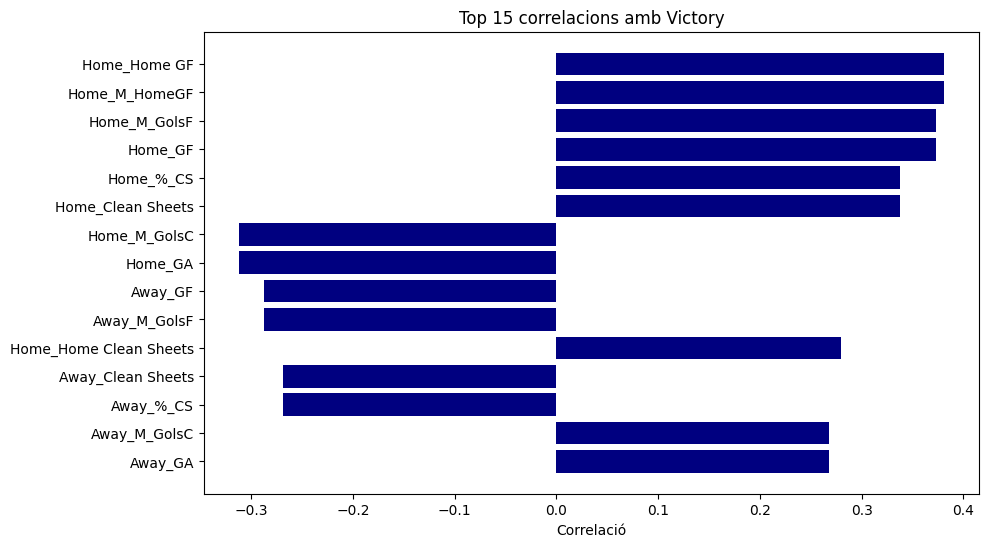


Top 15 correlacions amb Total_Goals:
1. shotsOnTarget: 0.415
2. shotPct: 0.331
3. Home_M_HomeGF: 0.289
4. Home_Home GF: 0.289
5. Home_GF: 0.277
6. Home_M_GolsF: 0.277
7. penaltyKickGoals: 0.212
8. totalShots: 0.202
9. penaltyKickShots: 0.176
10. totalLongBalls: -0.169
11. crossPct: 0.142
12. longballPct: 0.133
13. passPct: 0.127
14. Away_M_GolsC: 0.121
15. Away_GA: 0.121


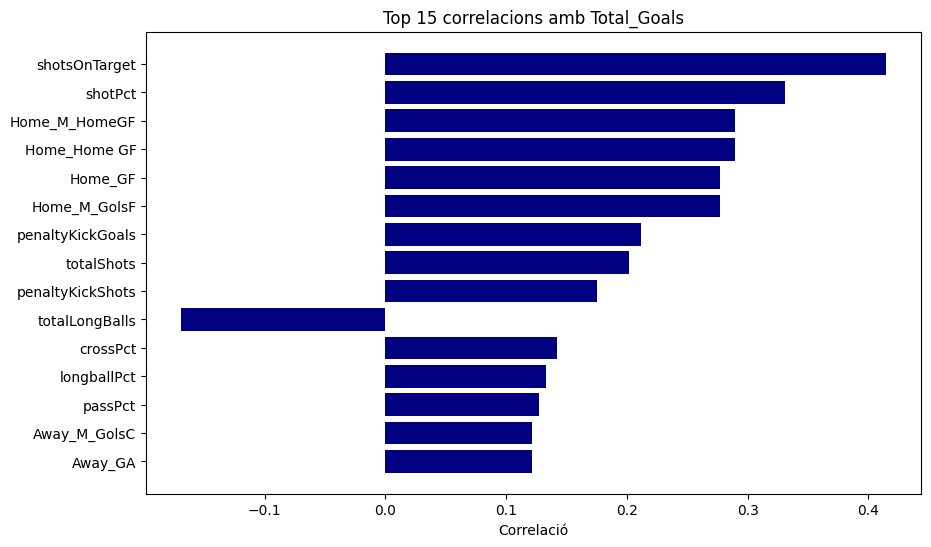

⚠️ La columna Goal_Difference no existeix!


In [4]:
print("ANÀLISI DE VARIABLES I CORRELACIONS")
print("=" * 50)

targets = ['Victory', 'Total_Goals', 'Goal_Difference']

# Codifiquem homeAway: 1 si juga a casa, 0 si juga fora
df_model['isHome'] = df_model['homeAway'].map({'home': 1, 'away': 0})

# Variables a excloure (derivades de resultats)
excloure_vars = [
    'Home_Victory', 'Home_%_Victories', 'Home_Empats', 'Home_%_Empats',
    'Home_Derrotes', 'Home_%_Derrotes', 'Home_GD', 'Home_Home Win',
    'Home_%_HomeWin', 'Home_Home Draw', 'Home_%_HomeDraw', 'Home_Home Loss',
    'Home_%_HomeLoss', 'Away_Victory', 'Away_%_Victories', 'Away_Empats',
    'Away_%_Empats', 'Away_Derrotes', 'Away_%_Derrotes', 'Away_GD',
    'Away_Home Win', 'Away_%_HomeWin', 'Away_Home Draw', 'Away_%_HomeDraw',
    'Away_Home Loss', 'Away_%_HomeLoss'
]

# Columnes numèriques de df_model
numeric_cols = df_model.select_dtypes(include='number').columns.tolist()

# Filtrar excloent variables derivades de resultat
features_cols = [col for col in numeric_cols if col not in excloure_vars + targets]

for target in targets:
    if target not in df_model.columns:
        print(f"⚠️ La columna {target} no existeix!")
        continue

    print(f"\nTop 15 correlacions amb {target}:")
    corr = df_model[features_cols + [target]].corr()[target].drop(target, errors='ignore')
    corr_abs_sorted = corr.abs().sort_values(ascending=False)
    top15 = corr_abs_sorted.head(15).index.tolist()

    for i, col in enumerate(top15, 1):
        print(f"{i}. {col}: {corr[col]:.3f}")

    plt.figure(figsize=(10, 6))
    values = corr[top15]
    plt.barh(range(len(values)), values.values, color='navy')
    plt.yticks(range(len(values)), top15)
    plt.xlabel('Correlació')
    plt.title(f'Top 15 correlacions amb {target}')
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
# !!! ELS MODELS VAN FATAL DE MOMENT EXCEPTE EL DE VICTÒRIA
# HEM DE TREURE VARIABLES DEL df_model NO RELLEVANTS FIXANT-NOS EN LES CORRELACIONS
# PODEM PROVAR TAMBÉ ALTRES TIPUS DE MODELS COM:
# Gradient Boosting (XGBoost, LightGBM), SVM, xarxes neuronals, o models ensemble.


print("ENTRENAMENT DE MODELS")
print("=" * 50)

# Eliminar duplicats de columnes a X
# El problema que teniem en el següent bloc era que Won_corners estava duplicat.
# Afegint això borrem columnes duplicades i ja no salta error
X = X.loc[:, ~X.columns.duplicated()]

# Assignar noms de features reals
X_features = X.columns.tolist()

# Divisió de dades
print("🔄 Dividint dades en entrenament i test...")

X_train, X_test, y_victory_train, y_victory_test = train_test_split(
    X, y_victory, test_size=0.2, random_state=42, stratify=y_victory
)

_, _, y_goals_train, y_goals_test = train_test_split(
    X, y_goals, test_size=0.2, random_state=42
)

_, _, y_corners_train, y_corners_test = train_test_split(
    X, y_corners, test_size=0.2, random_state=42
)

_, _, y_result_train, y_result_test = train_test_split(
    X, y_result, test_size=0.2, random_state=42, stratify=y_result
)

print(f"📚 Dades d'entrenament: {X_train.shape}")
print(f"🧪 Dades de test: {X_test.shape}")

# Entrenament dels models
print("\n🤖 ENTRENAMENT DELS MODELS")
print("=" * 50)

# De moment fem servir random forests i ja anirem provant
# Model 1: Predicció de victòria
print("\n1️⃣ Model de Predicció de Victòria")
model_victory = RandomForestClassifier(n_estimators=100, random_state=42)
model_victory.fit(X_train, y_victory_train)
victory_pred = model_victory.predict(X_test)
victory_accuracy = accuracy_score(y_victory_test, victory_pred)
print(f"   ✅ Precisió: {victory_accuracy:.3f}")

# Model 2: Predicció de gols totals
print("\n2️⃣ Model de Predicció de Gols Totals")
model_goals = RandomForestRegressor(n_estimators=100, random_state=42)
model_goals.fit(X_train, y_goals_train)
goals_pred = model_goals.predict(X_test)
goals_mse = mean_squared_error(y_goals_test, goals_pred)
print(f"   ✅ RMSE: {np.sqrt(goals_mse):.3f}")

# Model 3: Predicció de corners
print("\n3️⃣ Model de Predicció de Corners")
model_corners = RandomForestRegressor(n_estimators=100, random_state=42)
model_corners.fit(X_train, y_corners_train)
corners_pred = model_corners.predict(X_test)
corners_mse = mean_squared_error(y_corners_test, corners_pred)
print(f"   ✅ RMSE: {np.sqrt(corners_mse):.3f}")

# Model 4: Predicció de resultat complet
print("\n4️⃣ Model de Predicció de Resultat")
model_result = RandomForestClassifier(n_estimators=100, random_state=42)
model_result.fit(X_train, y_result_train)
result_pred = model_result.predict(X_test)
result_accuracy = accuracy_score(y_result_test, result_pred)
print(f"   ✅ Precisió: {result_accuracy:.3f}")

print("\n📊 Report de classificació (Resultat):")
print(classification_report(y_result_test, result_pred))
# En precisió, com més alt millor
# En RMSE com més baix millor: RMSE de 2 vol dir que s'equivoca en dues unitats
# Si s'equivoca de dos gols és molt dolent

ENTRENAMENT DE MODELS
🔄 Dividint dades en entrenament i test...
📚 Dades d'entrenament: (608, 80)
🧪 Dades de test: (152, 80)

🤖 ENTRENAMENT DELS MODELS

1️⃣ Model de Predicció de Victòria
   ✅ Precisió: 0.737

2️⃣ Model de Predicció de Gols Totals
   ✅ RMSE: 1.971

3️⃣ Model de Predicció de Corners
   ✅ RMSE: 3.012

4️⃣ Model de Predicció de Resultat
   ✅ Precisió: 0.382

📊 Report de classificació (Resultat):
              precision    recall  f1-score   support

    Away_Win       0.35      0.21      0.26        42
        Draw       0.21      0.09      0.13        43
    Home_Win       0.42      0.67      0.52        67

    accuracy                           0.38       152
   macro avg       0.33      0.33      0.30       152
weighted avg       0.34      0.38      0.34       152




🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES

🏆 Top 10 features per a predicció de victòria:
  45. Home_%_HomeWin            0.0274
  31. Home_%_Victories          0.0262
  40. Home_GD                   0.0256
  50. Home_Home GF              0.0256
  44. Home_Home Win             0.0253
  30. Home_Victory              0.0248
  60. Away_Derrotes             0.0227
  37. Home_M_GolsF              0.0226
  66. Away_GD                   0.0219
  17. totalCrosses              0.0207

⚽ Top 10 features per a predicció de gols:
   7. possessionPct             0.0535
  19. accurateLongBalls         0.0519
   1. foulsCommitted            0.0507
  17. totalCrosses              0.0397
  20. totalLongBalls            0.0388
  24. totalTackles              0.0362
  14. totalPasses               0.0361
  13. accuratePasses            0.0352
   6. saves                     0.0300
  23. effectiveTackles          0.0265


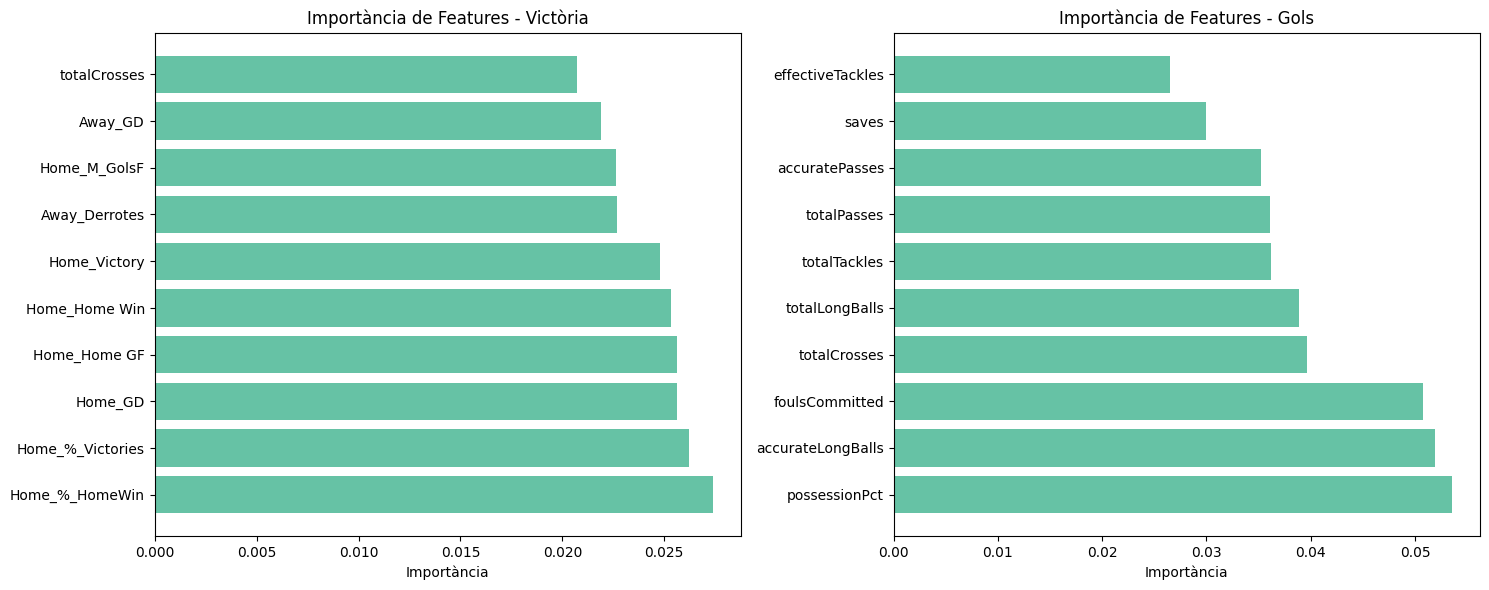


📊 ANÀLISI DE RENDIMENT


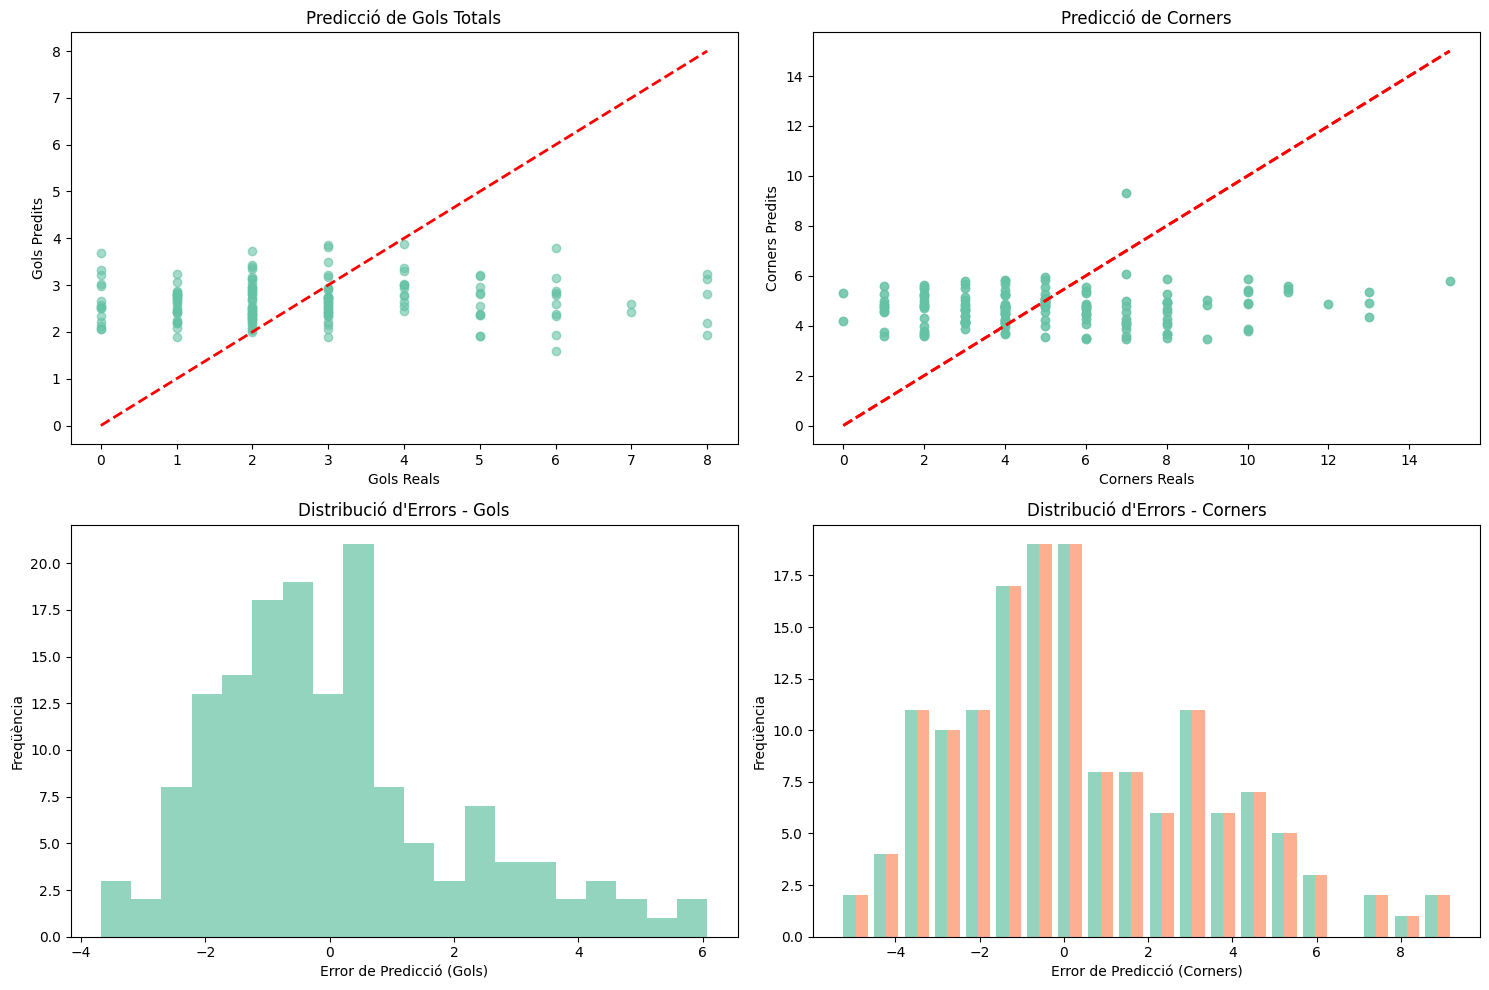


�� Resum de rendiment dels models:
- Precisió victòria: 73.7%
- RMSE gols: 1.97
- RMSE corners: 3.01
- Precisió resultat: 38.2%


In [13]:
print("\n🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES")
print("=" * 50)

# Obtenim importància per a cada model
feature_importance_victory = pd.DataFrame({
    'feature': X_features,
    'importance': model_victory.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_goals = pd.DataFrame({
    'feature': X_features,
    'importance': model_goals.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 10 features per a predicció de victòria:")
for i, row in feature_importance_victory.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

print("\n⚽ Top 10 features per a predicció de gols:")
for i, row in feature_importance_goals.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualització de la importància de features
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
top_features_victory = feature_importance_victory.head(10)
plt.barh(range(len(top_features_victory)), top_features_victory['importance'])
plt.yticks(range(len(top_features_victory)), top_features_victory['feature'])
plt.title('Importància de Features - Victòria')
plt.xlabel('Importància')

plt.subplot(1, 2, 2)
top_features_goals = feature_importance_goals.head(10)
plt.barh(range(len(top_features_goals)), top_features_goals['importance'])
plt.yticks(range(len(top_features_goals)), top_features_goals['feature'])
plt.title('Importància de Features - Gols')
plt.xlabel('Importància')

plt.tight_layout()
plt.show()

# Anàlisi de rendiment dels models
print("\n📊 ANÀLISI DE RENDIMENT")
print("=" * 50)

# Comparació de prediccions vs valors reals
plt.figure(figsize=(15, 10))

# Predicció de gols
plt.subplot(2, 2, 1)
plt.scatter(y_goals_test, goals_pred, alpha=0.6)
plt.plot([y_goals_test.min(), y_goals_test.max()], [y_goals_test.min(), y_goals_test.max()], 'r--', lw=2)
plt.xlabel('Gols Reals')
plt.ylabel('Gols Predits')
plt.title('Predicció de Gols Totals')

# Predicció de corners
plt.subplot(2, 2, 2)
plt.scatter(y_corners_test, corners_pred, alpha=0.6)
plt.plot([y_corners_test.min(), y_corners_test.max()], [y_corners_test.min(), y_corners_test.max()], 'r--', lw=2)
plt.xlabel('Corners Reals')
plt.ylabel('Corners Predits')
plt.title('Predicció de Corners')

# Distribució d'errors de gols
plt.subplot(2, 2, 3)
errors_goals = y_goals_test - goals_pred
plt.hist(errors_goals, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Gols)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Gols')

# Distribució d'errors de corners
plt.subplot(2, 2, 4)
errors_corners = y_corners_test - corners_pred
plt.hist(errors_corners, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Corners)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Corners')

plt.tight_layout()
plt.show()

# Resum de mètriques
print(f"\n�� Resum de rendiment dels models:")
print(f"- Precisió victòria: {victory_accuracy:.1%}")
print(f"- RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"- RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"- Precisió resultat: {result_accuracy:.1%}")

In [ ]:
print("FUNCIÓ DE PREDICCIÓ")
print("=" * 50)

# Funció per fer prediccions
def predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models):
    """
    Prediu el resultat d'un partit específic
    """
    
    # Obtenim estadístiques dels equips
    stats_local = df_classificacio[df_classificacio['Team'] == equip_local]
    stats_visitant = df_classificacio[df_classificacio['Team'] == equip_visitant]
    
    if stats_local.empty or stats_visitant.empty:
        print(f"⚠️  No s'han trobat les dades per a {equip_local} o {equip_visitant}")
        return None
    
    # Creem vector de features
    features_partit = {}
    
    # Estadístiques dels equips
    for col in df_classificacio.columns:
        if col != 'Team':
            features_partit[f'Home_{col}'] = stats_local[col].iloc[0]
            features_partit[f'Away_{col}'] = stats_visitant[col].iloc[0]
    
    # Valors mitjans per a estadístiques del partit
    for col in X_features:
        if col not in features_partit:
            features_partit[col] = df_model[col].mean()
    
    # Convertim a DataFrame
    df_prediccio = pd.DataFrame([features_partit])
    X_prediccio = df_prediccio[X_features]
    
    # Fem prediccions
    prob_victory = models['victory'].predict_proba(X_prediccio)[0][1]
    pred_goals = models['goals'].predict(X_prediccio)[0]
    pred_corners = models['corners'].predict(X_prediccio)[0]
    pred_result = models['result'].predict(X_prediccio)[0]
    
    return {
        'equip_local': equip_local,
        'equip_visitant': equip_visitant,
        'probabilitat_victoria_local': f"{prob_victory:.1%}",
        'gols_totals_previstos': f"{pred_goals:.1f}",
        'corners_previstos': f"{pred_corners:.1f}",
        'resultat_previst': pred_result
    }

# Diccionari amb els models
models = {
    'victory': model_victory,
    'goals': model_goals,
    'corners': model_corners,
    'result': model_result
}

print("EXEMPLES DE PREDICCIÓ")
print("=" * 50)

# Exemple 1
print("\n🏆 Real Madrid vs Barcelona:")
prediccio1 = predir_partit('Real Madrid', 'Barcelona', df_classificacio, df_model, X_features, models)
if prediccio1:
    for key, value in prediccio1.items():
        print(f"  {key}: {value}")

# Exemple 2
print("\n⚽ Girona vs Atlético Madrid:")
prediccio2 = predir_partit('Girona', 'Atlético Madrid', df_classificacio, df_model, X_features, models)
if prediccio2:
    for key, value in prediccio2.items():
        print(f"  {key}: {value}")

# Exemple 3
print("\n🔵 Barcelona vs Real Madrid:")
prediccio3 = predir_partit('Barcelona', 'Real Madrid', df_classificacio, df_model, X_features, models)
if prediccio3:
    for key, value in prediccio3.items():
        print(f"  {key}: {value}")

# Funció per fer prediccions personalitzades
def fer_prediccio_personalitzada():
    """
    Funció interactiva per fer prediccions personalitzades
    """
    print("\n💬 Predicció Personalitzada")
    print("-" * 30)
    
    # Mostrem equips disponibles
    print("📋 Equips disponibles:")
    for i, equip in enumerate(df_classificacio['Team'].values, 1):
        print(f"  {i:2d}. {equip}")
    
    # Demanem equips
    try:
        equip_local = input("\n🏠 Equip local: ")
        equip_visitant = input("✈️  Equip visitant: ")
        
        # Fem la predicció
        prediccio = predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models)
        
        if prediccio:
            print(f"\n🎯 PREDICCIÓ: {equip_local} vs {equip_visitant}")
            print("=" * 40)
            for key, value in prediccio.items():
                print(f"  {key}: {value}")
        else:
            print("❌ No s'ha pogut fer la predicció. Verifica els noms dels equips.")
            
    except KeyboardInterrupt:
        print("\n🛑 Fi del programa")
    except Exception as e:
        print(f"❌ Error: {e}")

print("\n💡 Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")


FUNCIÓ DE PREDICCIÓ
EXEMPLES DE PREDICCIÓ

🏆 Real Madrid vs Barcelona:


ValueError: setting an array element with a sequence.

In [ ]:
print("\n�� RESUM DEL MODEL")
print("=" * 50)

print(f"\n📊 Dades utilitzades:")
print(f"  - Partits analitzats: {len(df_partits)}")
print(f"  - Equips disponibles: {len(df_classificacio)}")
print(f"  - Features utilitzades: {len(X_features)}")

print(f"\n🤖 Models entrenats:")
print(f"  - Predicció de victòria (Classificació)")
print(f"  - Predicció de gols totals (Regressió)")
print(f"  - Predicció de corners (Regressió)")
print(f"  - Predicció de resultat (Classificació multiclasse)")

print(f"\n📈 Rendiment dels models:")
print(f"  - Precisió victòria: {victory_accuracy:.1%}")
print(f"  - RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"  - RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"  - Precisió resultat: {result_accuracy:.1%}")

print(f"\n🎯 Variables més importants:")
print(f"  - Per victòria: {feature_importance_victory.iloc[0]['feature']}")
print(f"  - Per gols: {feature_importance_goals.iloc[0]['feature']}")

print(f"\n✅ El model està llest per a fer prediccions!")

print("\n🚀 Script completat amb èxit!")
print("💡 Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")